In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
def angle360(x,y):
    return abs(math.degrees(np.arctan2(y,x))) if y < 0 else abs(math.degrees(np.arctan2(y,x))-360)


In [4]:
#get directories and open separated datasets

time_interval = 10 #sec/frame

datadir = 'E:/Aaron/Combined_37C_Confocal_PCA_smooth/Data_and_Figs/'
savedir = datadir + 'alldata/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())

# make sure all categories are ordered
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['Random','Pre-Galvanotaxis','Galvanotaxis','DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
TotalFrame['Experiment'] = pd.Categorical(TotalFrame.Experiment.to_list(), categories=['Galvanotaxis','Drug'], ordered=True)

In [3]:
################# get "n" of the dataset ###########
print(f'There are {len(TotalFrame)} images of {len(TotalFrame.CellID.unique())} unique cells')

There are 107765 images of 1470 unique cells


In [4]:
############## create x-y and x-z turn angles ################
allcells = []

xyangles=[]
xzangles = []
for i, cell in TotalFrame.sort_values(by=['CellID','frame']).reset_index(drop=True).groupby('CellID'):
    for r, row in cell.iterrows():
        if any(row[[i for i in TotalFrame.columns.to_list() if 'Traj' in i]].isna()):
            xyangles.append(np.nan)
            xzangles.append(np.nan)
        else:
            xyangles.append(angle(row['Prev_Trajectory_X'], row['Prev_Trajectory_Y'],row['Trajectory_X'],row['Trajectory_Y']))
            xzangles.append(angle(row['Prev_Trajectory_X'], row['Prev_Trajectory_Z'],row['Trajectory_X'],row['Trajectory_Z']))

#     cell['xyangles'] = xyangles
#     cell['xzangles'] = xzangles
#     allcells.append(cell)
TotalFrame['xyangles'] = xyangles
TotalFrame['xzangles'] = xzangles

In [5]:
############### Get Correlation matrix #######################


# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove = [i for i in TotalFrame.columns.to_list() if 'bin' in i]
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory_' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


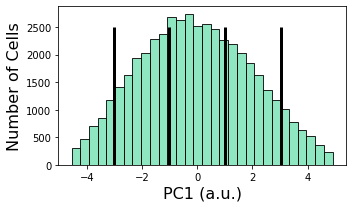

In [63]:
############## nice PC1 histogram ###############3
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.histplot(data = TotalFrame, x = 'PC1', bins = 30, color = '#69E0AC', ax=ax)
ax.set_xlabel('PC1 (a.u.)', fontsize = 16)
ax.set_ylabel('Number of Cells', fontsize = 16)
ax.vlines(TotalFrame.PC1.std()*0.5,0,2500, lw = 3, color = 'black')
ax.vlines(TotalFrame.PC1.std()*-0.5,0,2500, lw = 3, color = 'black')
ax.vlines(TotalFrame.PC1.std()*1.5,0,2500, lw = 3, color = 'black')
ax.vlines(TotalFrame.PC1.std()*-1.5,0,2500, lw = 3, color = 'black')
plt.tight_layout()
plt.savefig(savedir + 'PC1 histogram.png', bbox_inches='tight')

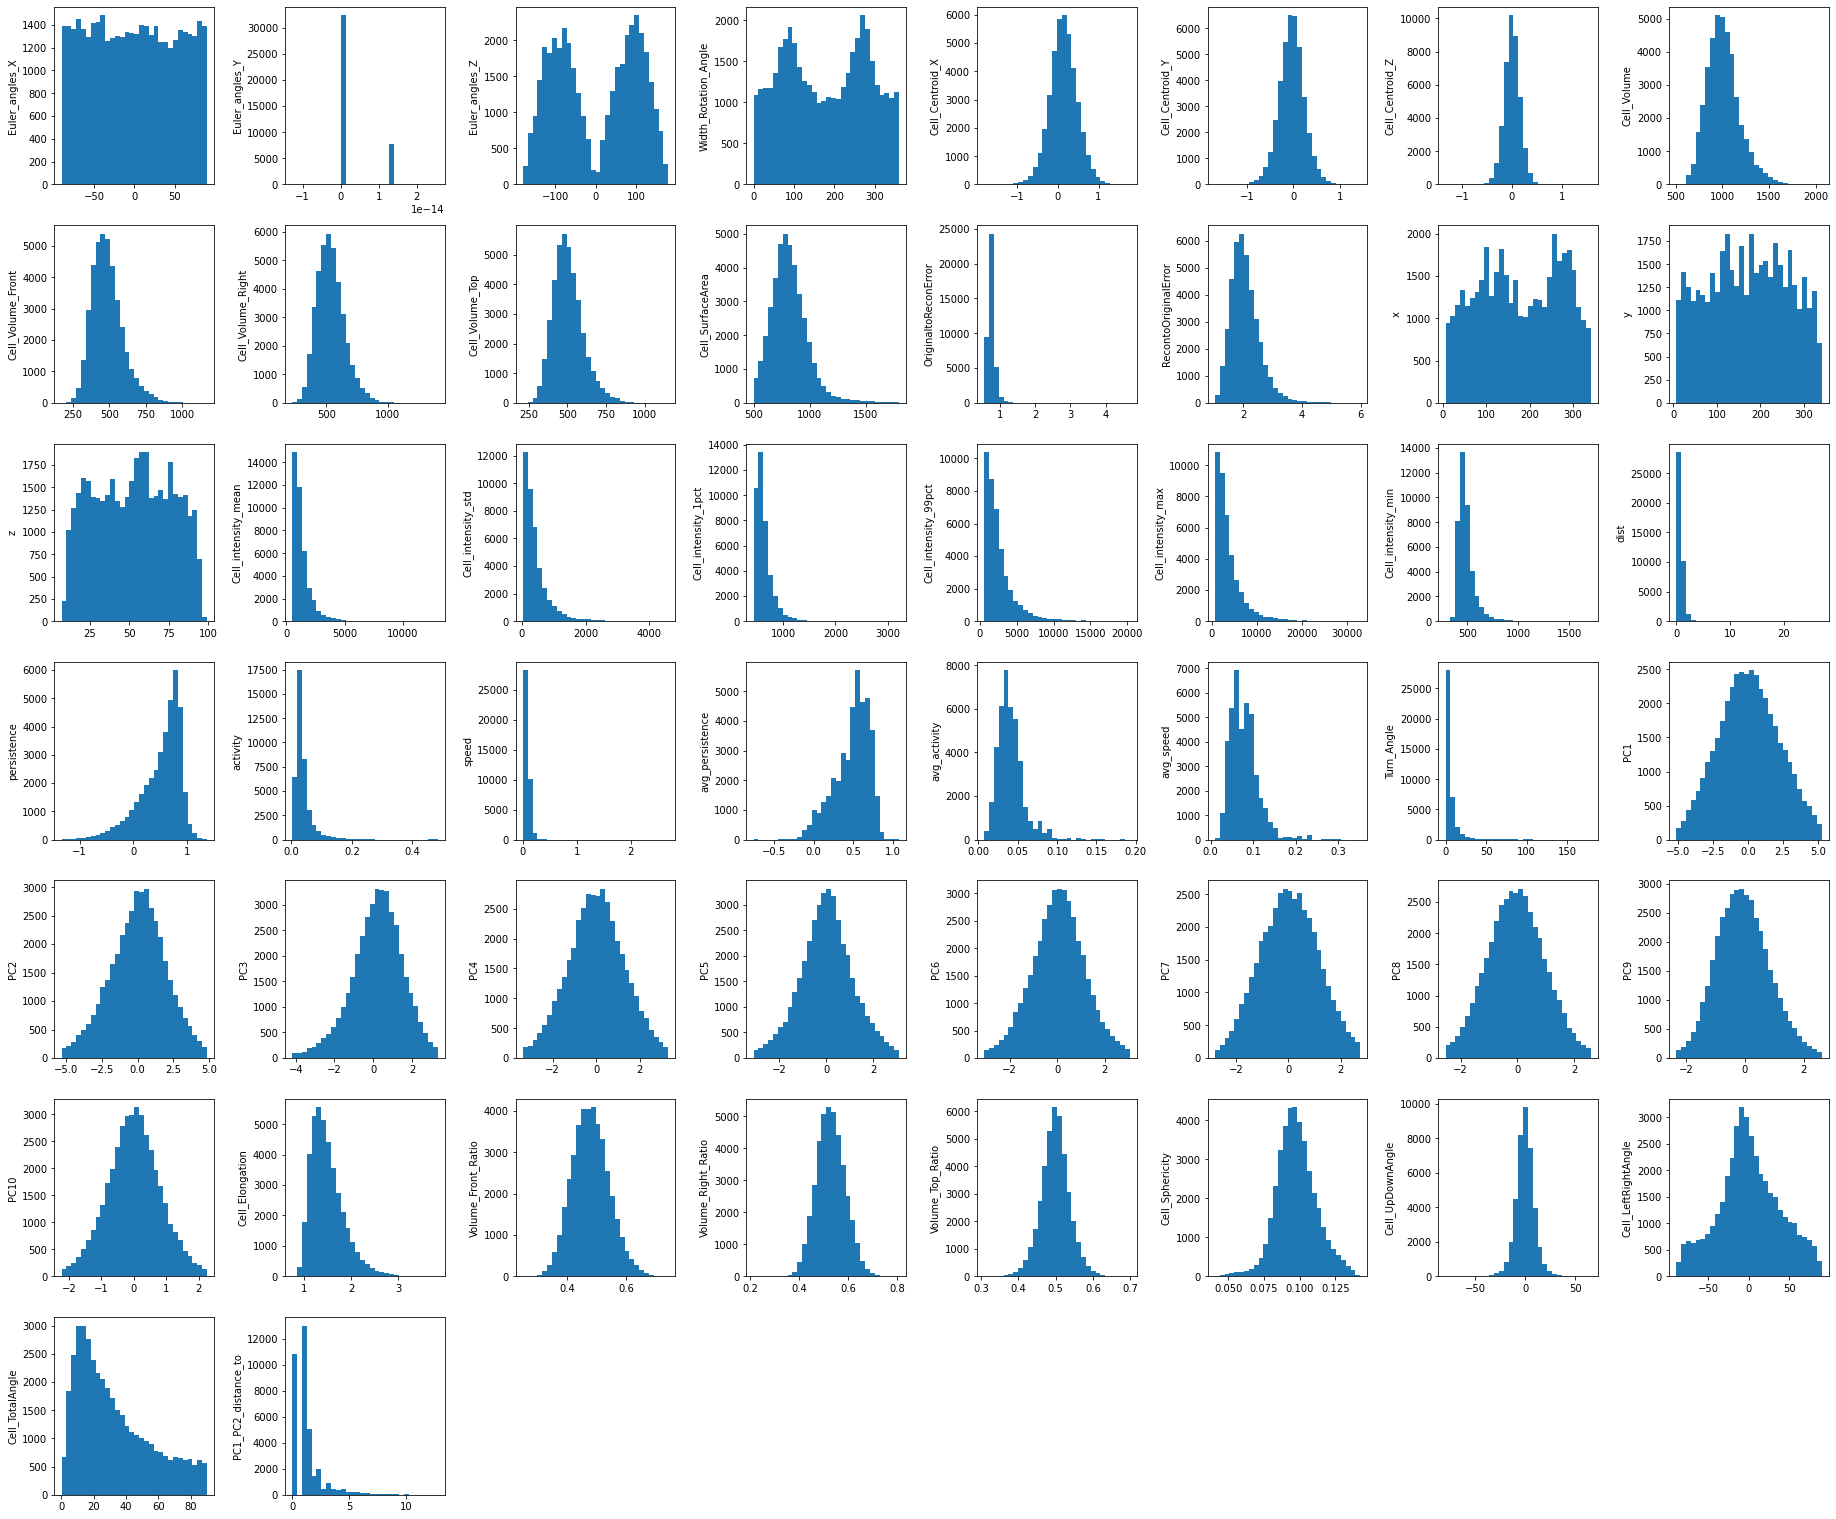

In [7]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame','Treatment'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
# plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

In [104]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])
ModeFrame.drop(columns=new_remove).columns.to_list()

['Cell_Volume',
 'Cell_Volume_Front',
 'Cell_Volume_Right',
 'Cell_Volume_Top',
 'Cell_SurfaceArea',
 'dist',
 'persistence',
 'speed',
 'avg_persistence',
 'avg_speed',
 'Instant_Signal_Velocity',
 'Signal_Velocity',
 'Total_Distance_Travelled',
 'Euclidean_Distance_Travelled',
 'Turn_Angle',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'Cell_Elongation',
 'Volume_Front_Ratio',
 'Volume_Right_Ratio',
 'Volume_Top_Ratio',
 'Cell_Sphericity',
 'Cell_UpDownAngle',
 'Cell_LeftRightAngle',
 'Cell_TotalAngle',
 'Date',
 'Treatment',
 'Temperature']

In [105]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment' and c!= 'Temperature':
        # Performing two-way ANOVA 
        model = ols(f'{c} ~ C(Treatment) + C(Temperature) + C(Treatment):C(Temperature)', 
                    data=ModeFrame).fit() 
        result = sm.stats.anova_lm(model, type=2) 


        if any(result['PR(>F)'].values <0.05):
            # Print the result 
            print(c, result) 
            siglist.append(c) 


Cell_Volume                                   df        sum_sq       mean_sq           F  \
C(Treatment)                     5.0  8.344649e+06  1.668930e+06   58.101100   
C(Temperature)                   1.0  2.007939e+07  2.007939e+07  699.031391   
C(Treatment):C(Temperature)      5.0  3.650827e+06  7.301654e+05   25.419529   
Residual                     78374.0  2.251261e+09  2.872458e+04         NaN   

                                    PR(>F)  
C(Treatment)                  1.431510e-60  
C(Temperature)               2.297186e-153  
C(Treatment):C(Temperature)   1.031933e-25  
Residual                               NaN  
Cell_Volume_Front                                   df        sum_sq       mean_sq           F  \
C(Treatment)                     5.0  3.452207e+06  6.904415e+05   62.609122   
C(Temperature)                   1.0  1.946741e+06  1.946741e+06  176.530153   
C(Treatment):C(Temperature)      5.0  2.144715e+06  4.289430e+05   38.896484   
Residual                

Euclidean_Distance_Travelled                                   df        sum_sq       mean_sq            F  \
C(Treatment)                     5.0  6.520264e+06  1.304053e+06  2716.565467   
C(Temperature)                   1.0  1.050430e+05  1.050430e+05   218.822513   
C(Treatment):C(Temperature)      5.0  1.974951e+05  3.949903e+04    82.283245   
Residual                     76519.0  3.673198e+07  4.800373e+02          NaN   

                                   PR(>F)  
C(Treatment)                 0.000000e+00  
C(Temperature)               1.912749e-49  
C(Treatment):C(Temperature)  1.767446e-86  
Residual                              NaN  
Turn_Angle                                   df        sum_sq       mean_sq           F  \
C(Treatment)                     5.0  9.616263e+04  19232.525838  155.612265   
C(Temperature)                   1.0  7.960705e+04  79607.054474  644.108536   
C(Treatment):C(Temperature)      5.0  2.387992e+03    477.598374    3.864296   
Residual      

Volume_Right_Ratio                                   df      sum_sq   mean_sq         F    PR(>F)
C(Treatment)                     5.0    0.125701  0.025140  6.331061  0.000007
C(Temperature)                   1.0    0.000593  0.000593  0.149450  0.699062
C(Treatment):C(Temperature)      5.0    0.035464  0.007093  1.786187  0.111865
Residual                     78374.0  311.217967  0.003971       NaN       NaN
Volume_Top_Ratio                                   df      sum_sq   mean_sq         F    PR(>F)
C(Treatment)                     5.0    0.017044  0.003409  2.002422  0.074905
C(Temperature)                   1.0    0.006502  0.006502  3.819129  0.050674
C(Treatment):C(Temperature)      5.0    0.020405  0.004081  2.397227  0.034988
Residual                     78374.0  133.422878  0.001702       NaN       NaN
Cell_Sphericity                                   df     sum_sq   mean_sq           F  \
C(Treatment)                     5.0   0.463206  0.092641  535.200850   
C(Temperatur

In [19]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('CellID'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Treatment':m,
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize

Treatment  Cells  Images
0                     DMSO    287   22027
1                    CK666     84    8264
2  Para-Nitro-Blebbistatin    144    9976

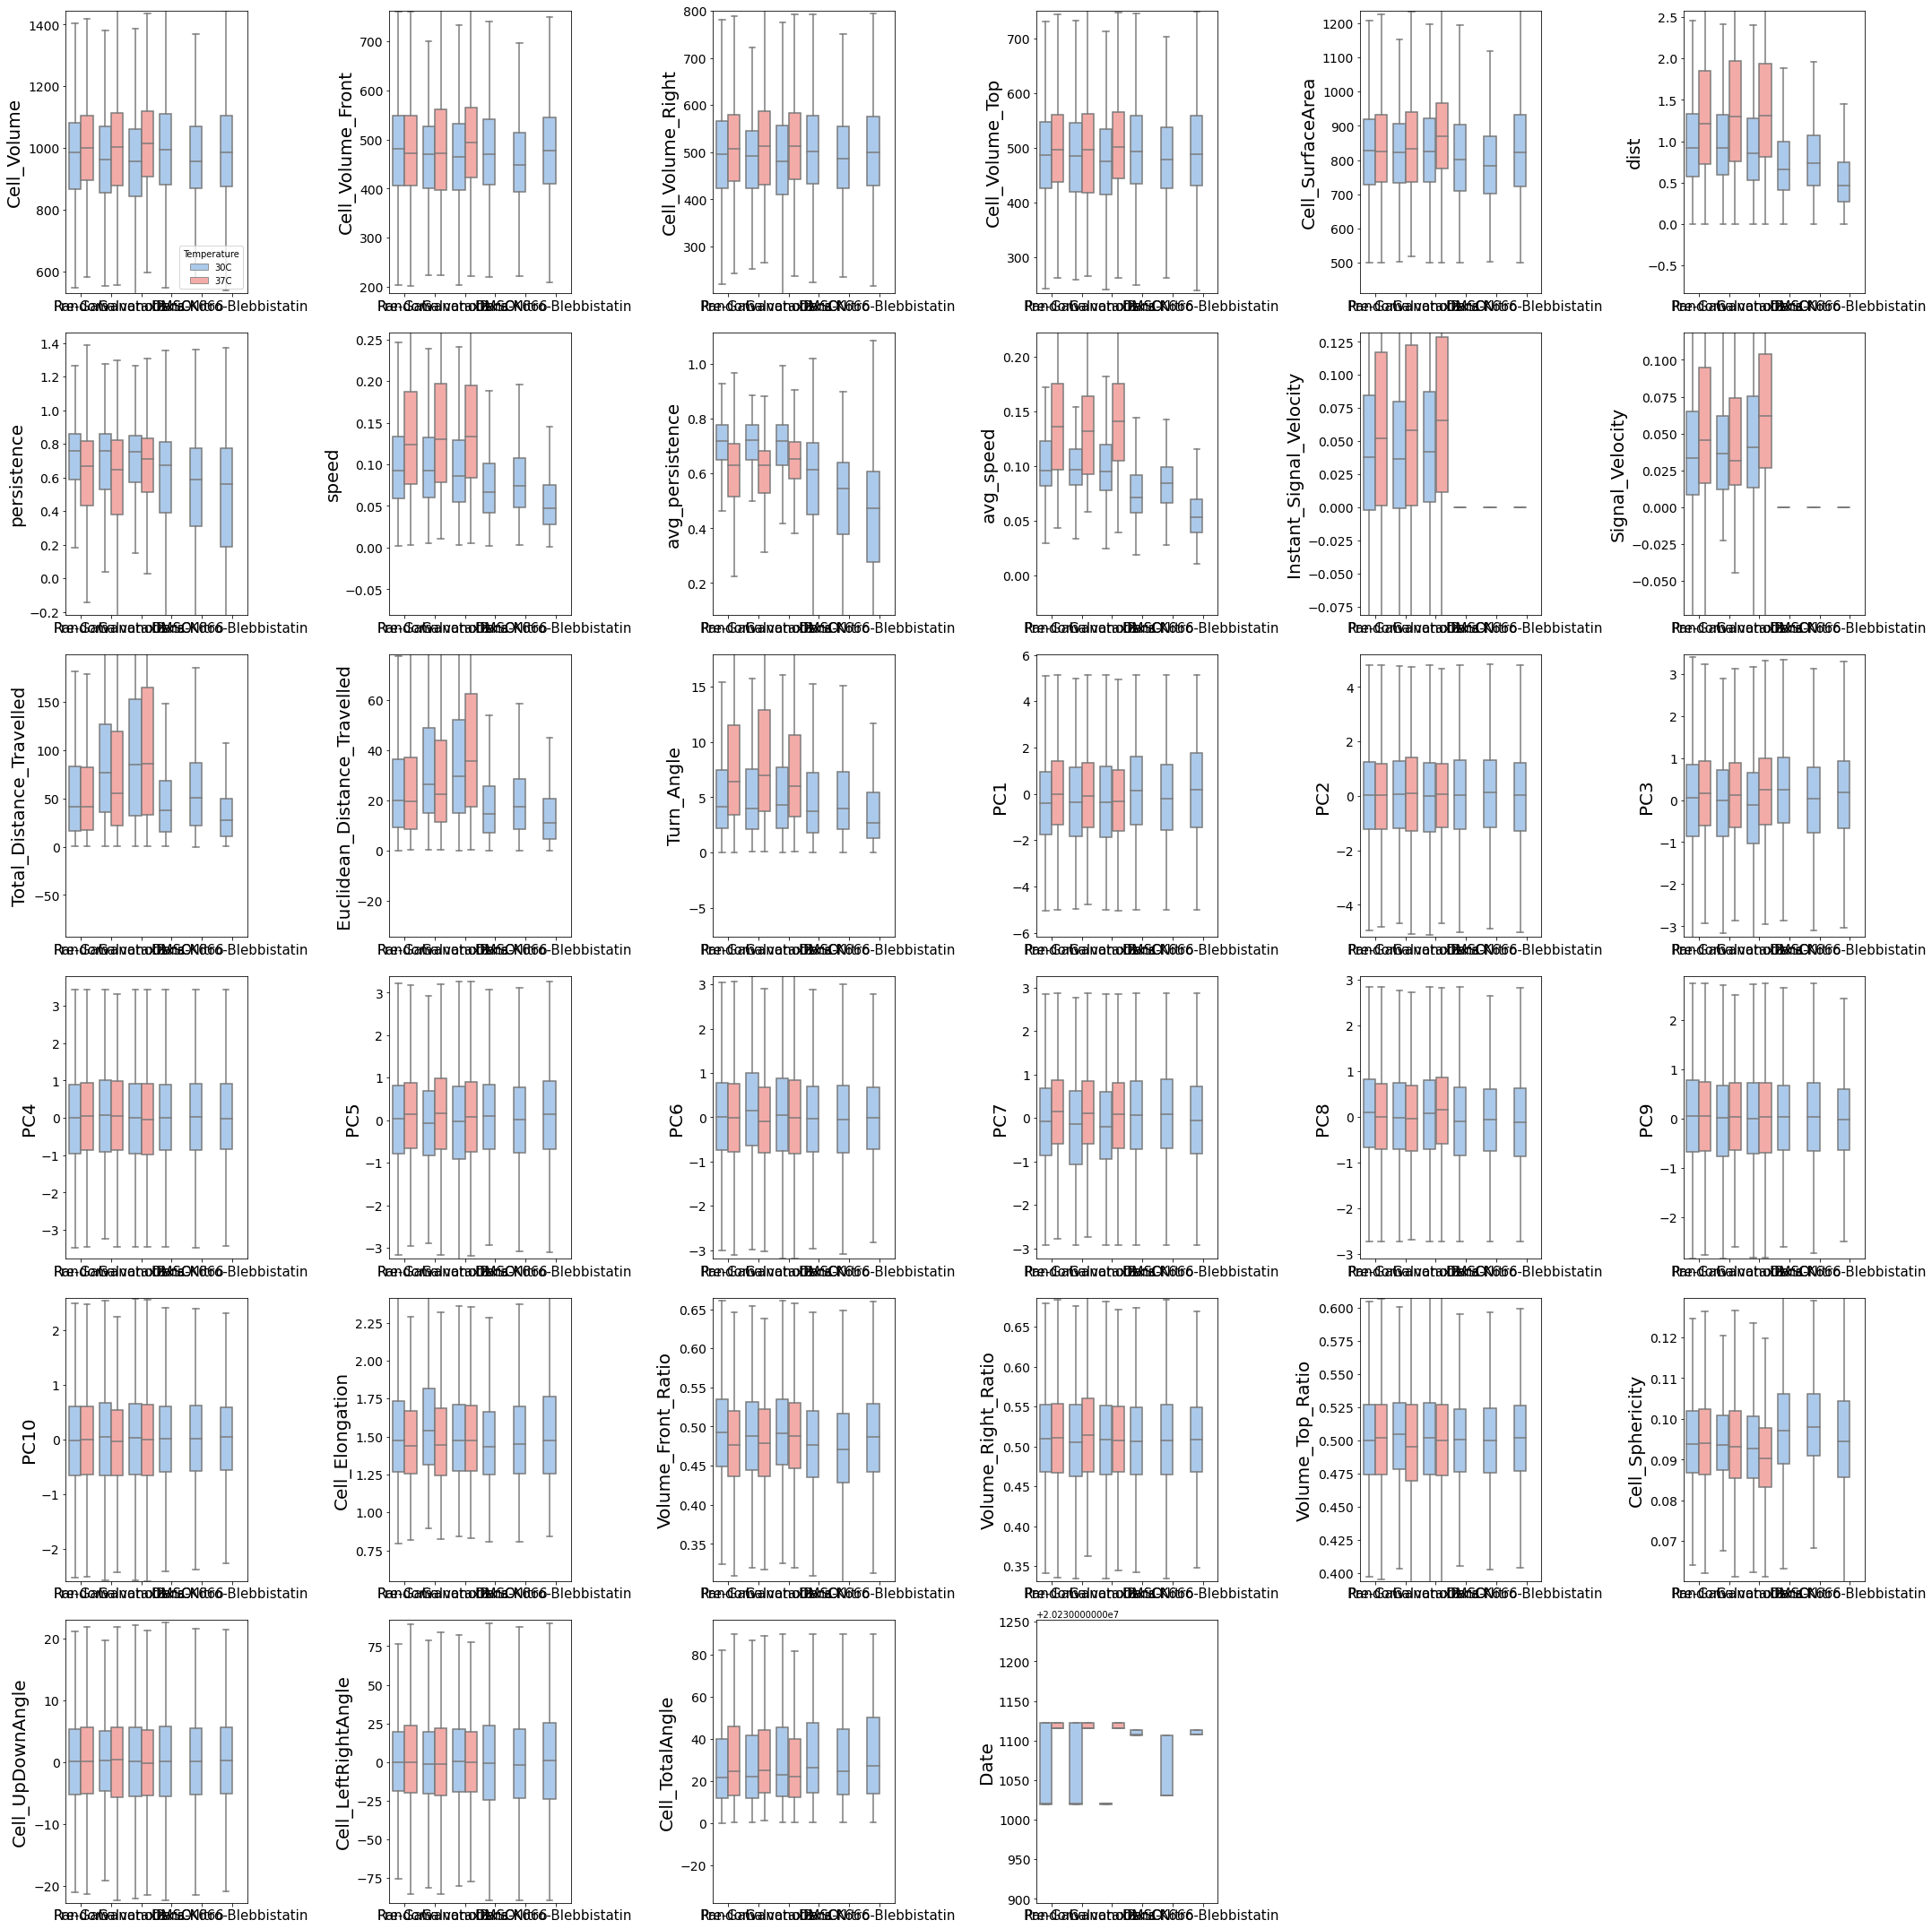

In [108]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

# smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation',
#               'Volume_Front_Ratio','Volume_Right_Ratio','speed','persistence',
#              'Turn_Angle', 'Cell_TotalAngle','Angular_Bias']
# siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell_Elongation (a.u.)',
#              'Front-Back Volume Ratio (a.u.)','Right-Left Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
#             'Turn Angle (°)', 'Cell_TotalAngle (°)','Angular Bias (°)']

sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.6*IQR, Q3 + 1.6*IQR)
    axli[i].set_ylabel(siglist[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')


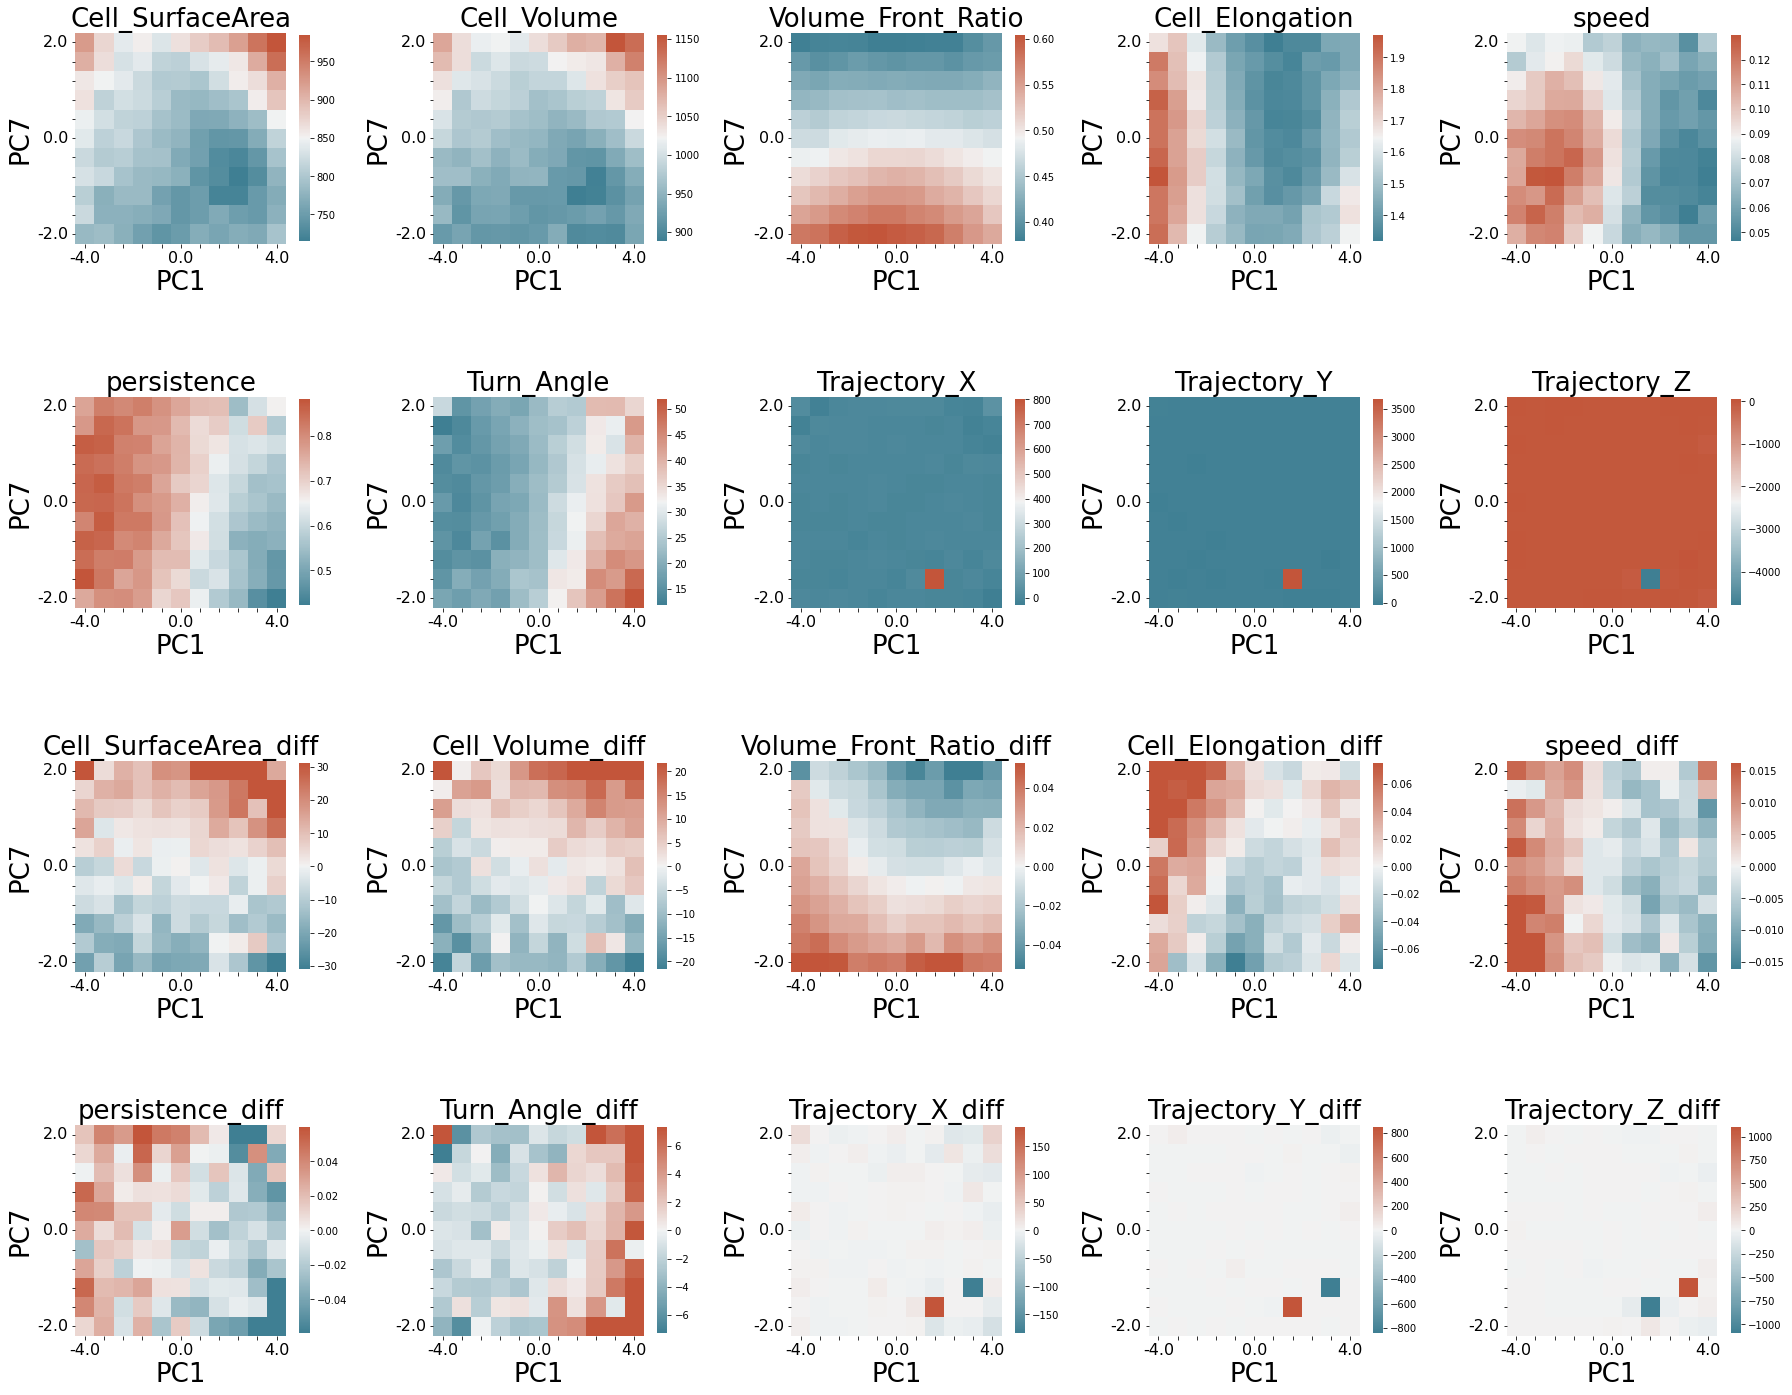

In [36]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed',
           'persistence','Turn_Angle','Trajectory_X','Trajectory_Y', 'Trajectory_Z']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC7bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = np.nanmean(current[diffmets[i]])


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]) if '_diff' not in diffmets[i] else 0-(bighm.std()*2),
            vmax=bighm.max() if '_diff' not in diffmets[i] else 0+(bighm.std()*2),
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC7.to_list()],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC7', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC7', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 all metric heatmaps.png', bbox_inches='tight')

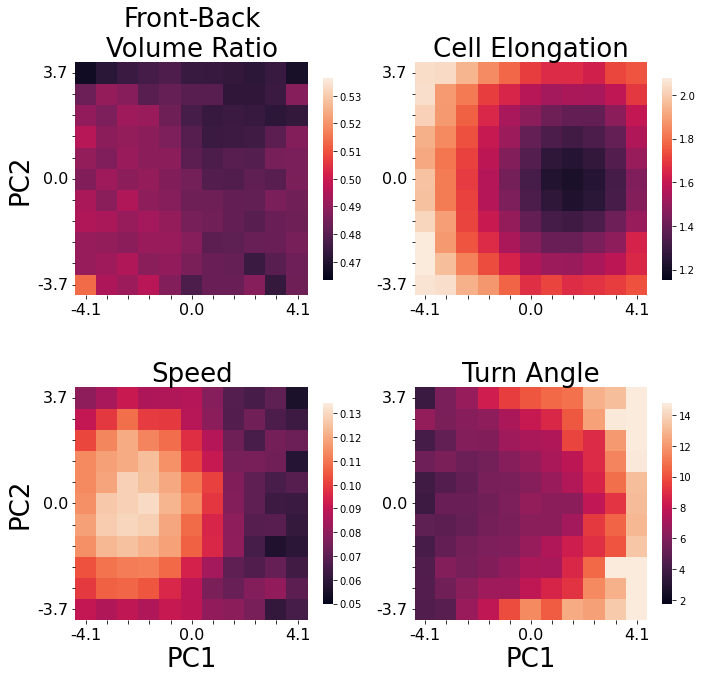

In [16]:
#################### PLOT FOR ASCB 2023 #####################

########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Volume_Front_Ratio','Cell_Elongation','speed','Turn_Angle']
Metricnames = ['Front-Back\nVolume Ratio', 'Cell Elongation','Speed','Turn Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
#                 print(x, y, len(current), current[diffmets[i]].mean())
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()

#         print(bighm.mean(), bighm.std())
        vmin = bighm.mean()-(bighm.std()*2) if diffmets[i] != 'Volume_Front_Ratio' else 0.5-(bighm.std()*5)
        vmax = bighm.mean()+(bighm.std()*2) if diffmets[i] != 'Volume_Front_Ratio' else 0.5+(bighm.std()*5)
        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=vmin, #np.min(bighm[np.nonzero(bighm)]),
            vmax=vmax, #bighm.max(), #center=0,
            cmap='rocket',#sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        if i==0:
            ax.set_ylabel('PC2', fontsize = 26)
        if i == 2:
            ax.set_xlabel('PC1', fontsize = 26)
            ax.set_ylabel('PC2', fontsize = 26)
        if i == 3:
            ax.set_xlabel('PC1', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(Metricnames[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
# axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight', dpi=500)

In [111]:
############## get 1D cycle for PC dynamics ##############
### get centered PC bins first
orig = [5, 6]
whichpcs = [1,8]

x = TotalFrame.PC1bins.values-orig[0]
y = TotalFrame.PC8bins.values-orig[1]
### calculate angular coord and radius
TotalFrame['PC1_PC8_Angular_Coord'] = [angle360(x1, y1) for x1, y1 in zip(x, y)]
TotalFrame['PC1_PC8_Radial_Coord'] = np.sqrt((x**2) + (y**2))
### "bin" the Angular coord
TotalFrame['PC1_PC8_Angular_Bins'] = [math.ceil(i) for i in TotalFrame['PC1_PC8_Angular_Coord']]


In [15]:
############## get 1D cycle for PC dynamics WITHOUT USING CGPS BINS ##############
orig = [5, 6]
whichpcs = [1,7]
binrange = 10
direction = 'counterclockwise'


### get centered PC bins first
x = TotalFrame[f'PC{whichpcs[0]}'].values-centers[f'PC{whichpcs[0]}'].iloc[orig[0]-1]
y = TotalFrame[f'PC{whichpcs[1]}'].values-centers[f'PC{whichpcs[1]}'].iloc[orig[1]-1]
### calculate angular coord and radius
TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord'] = [angle360(x1, y1) for x1, y1 in zip(x, y)]
TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Radial_Coord'] = np.sqrt((x**2) + (y**2))
### "bin" the Angular coord
if direction == 'clockwise':
    TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'] = np.digitize(TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord'].to_numpy(),
                           np.arange(0,360+binrange,binrange))
elif direction == 'counterclockwise':
    TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'] = np.digitize(TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord'].to_numpy(),
                           np.arange(0,360+binrange,binrange)[::-1])
TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'] = (TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'] * binrange) - binrange

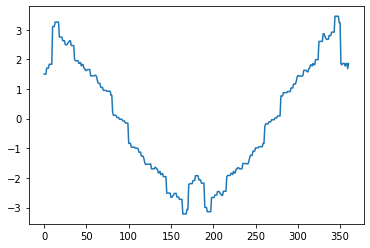

In [160]:
################ GET THE CYCLE RUNNING AVERAGE #####################
N=20
cont = TotalFrame[['PC1_PC8_Angular_Bins','PC1']].sort_values('PC1_PC8_Angular_Bins').values.T
early = cont[:,np.where(cont[0,:]>360-N)[0]].astype('float')
early[0,:] -= 360
late = cont[:,np.where(cont[0,:]>360-N)[0]].astype('float')
late[0,:] += N
newcont = np.hstack((early,cont,late))
newcont.shape
runav = np.zeros((361))
for r in range(361):
    runav[r] = np.mean(newcont[:,np.where((newcont[0,:]>r-(N/2))&(newcont[0,:]<r+(N/2)))[0]],1)[1]
plt.plot(runav)

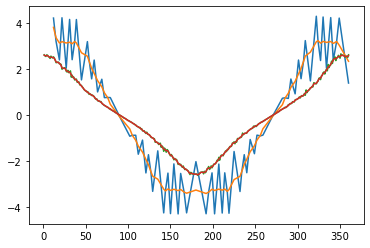

In [71]:
ra = TotalFrame[['PC1_PC8_Angular_Bins','PC1']].groupby('PC1_PC8_Angular_Bins').mean()
ca = TotalFrame[['PC1_PC8_Continuous_Angular_Bins','PC1']].groupby('PC1_PC8_Continuous_Angular_Bins').mean()

plt.plot(ra.index.values,ra.PC1.values, label='bins')
plt.plot(ra.index.values,scipy.ndimage.gaussian_filter1d(ra.PC1.values,1), label = 'bins smooth')
plt.plot(ca.index.values,ca.PC1.values, label='cont bins')
plt.plot(ca.index.values,scipy.ndimage.gaussian_filter1d(ca.PC1.values,1), label = 'cont bins smooth')

In [84]:
############### get animated PC1 and PC8 around average 1D cycle #############
from CustomFunctions.PCvisualization import animate_PCs
import pickle as pk
from pathlib import Path

#make the directory to save this combined image
specificdir = savedir +f'/PC{whichpcs[0]}-PC{whichpcs[1]}_Cycle_Visualization/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)

#get the average of each PC
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and '_' not in x]].mean().to_numpy()
#open the actual pca file used to analyze this dataset
pca = pk.load(open(str(Path(savedir).parents[0])+"/pca.pkl",'rb'))
#define which PCs to incorporate into the view

lmax = 10

allinterpvals = []
for w in whichpcs:
    ra = TotalFrame[[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins',f'PC{w}']].groupby(f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins').mean().reset_index()
    pre = ra.values[-5:]
    pre[:,0] -=360
    post = ra.values[:5]
    post[:,0] += 360
    newra = np.vstack((pre, ra.values, post))
    f = scipy.interpolate.interp1d(newra[:,0], scipy.ndimage.gaussian_filter1d(newra[:,1],1))
    interpvals = f(np.arange(0,360,binrange))
    allinterpvals.append(interpvals)

for i, a in enumerate(np.array(allinterpvals).T):
    cursavedir = specificdir + f'frame_{int(i)}_PC{whichpcs[0]}_and_PC{whichpcs[1]}_mesh.vtp'
    animate_PCs(avgpcs,
                whichpcs,
                a,
                pca,
                cursavedir,
                lmax,)



In [81]:
############### get animated representation of ALL PCs around average 1D cycle #############
from CustomFunctions.PCvisualization import animate_PCs
import pickle as pk
from pathlib import Path

#make the directory to save this combined image
specificdir = savedir +'/PC1-PC8_Cycle_All_Visualization/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)

#get the average of each PC
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and '_' not in x]].mean().to_numpy()
#open the actual pca file used to analyze this dataset
pca = pk.load(open(str(Path(savedir).parents[0])+"/pca.pkl",'rb'))
#define which PCs to incorporate into the view
whichpcs = list(range(1,len(avgpcs)+1))

lmax = 10

#use 1D gaussian smoothening to get average PC curves over the 1D cycle
allinterpvals = []
for w in whichpcs:
    ra = TotalFrame[['PC1_PC8_Continuous_Angular_Bins',f'PC{w}']].groupby('PC1_PC8_Continuous_Angular_Bins').mean().reset_index()
    pre = ra.values[-5:]
    pre[:,0] -=360
    post = ra.values[:5]
    post[:,0] += 360
    newra = np.vstack((pre, ra.values, post))
    f = scipy.interpolate.interp1d(newra[:,0], scipy.ndimage.gaussian_filter1d(newra[:,1],1))
    interpvals = f(np.arange(0,360,binrange))
    allinterpvals.append(interpvals)

for i, a in enumerate(np.array(allinterpvals).T):
    cursavedir = specificdir + f'frame_{int(i)}_mesh.vtp'
    animate_PCs(avgpcs,
                whichpcs,
                a,
                pca,
                cursavedir,
                lmax,)



In [97]:
############### get animated representation of USING AVERAGE SHCOEFFS around average 1D cycle #############
from CustomFunctions.shtools_mod import get_even_reconstruction_from_coeffs
from CustomFunctions.PCvisualization import save_mesh
import pickle as pk
from pathlib import Path

#open coeffs file
coeff_df = pd.read_csv(datadir+'Shape_Metrics_with_Digitized_PCs.csv')
# coeff_df = coeff_df[[x for x in coeff_df.columns.to_list() if 'shco' in x]+['cell']]
coeffframe = TotalFrame.merge(coeff_df[[x for x in coeff_df.columns.to_list() if 'shco' in x]+['cell']],
                              left_on = 'cell', right_on = 'cell')

#make the directory to save this combined image
specificdir = savedir +f'/PC{whichpcs[0]}-PC{whichpcs[1]}_Cycle_AllSHCoeff_Visualization/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)


lmax = 10

#use 1D gaussian smoothening to get average PC curves over the 1D cycle
allinterpvals = []
for s in [x for x in coeffframe if 'shco' in x]:
    ra = coeffframe[[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins',s]].groupby(f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins').mean().reset_index()
    pre = ra.values[-5:]
    pre[:,0] -= 360
    post = ra.values[:5]
    post[:,0] += 360
    newra = np.vstack((pre, ra.values, post))
    f = scipy.interpolate.interp1d(newra[:,0], scipy.ndimage.gaussian_filter1d(newra[:,1],1))
    if direction == 'clockwise':
        interpvals = f(np.arange(0,360,binrange))
    elif direction == 'counterclockwise':
        interpvals = f(np.arange(0,360,binrange)[::-1])
    allinterpvals.append(interpvals)

for i, a in enumerate(np.array(allinterpvals).T):
    mesh, _ = get_even_reconstruction_from_coeffs(np.reshape(a, (2,lmax+1,lmax+1)), lmax)
    save_mesh(mesh, specificdir + f'frame_{int(i)}_mesh.vtp')


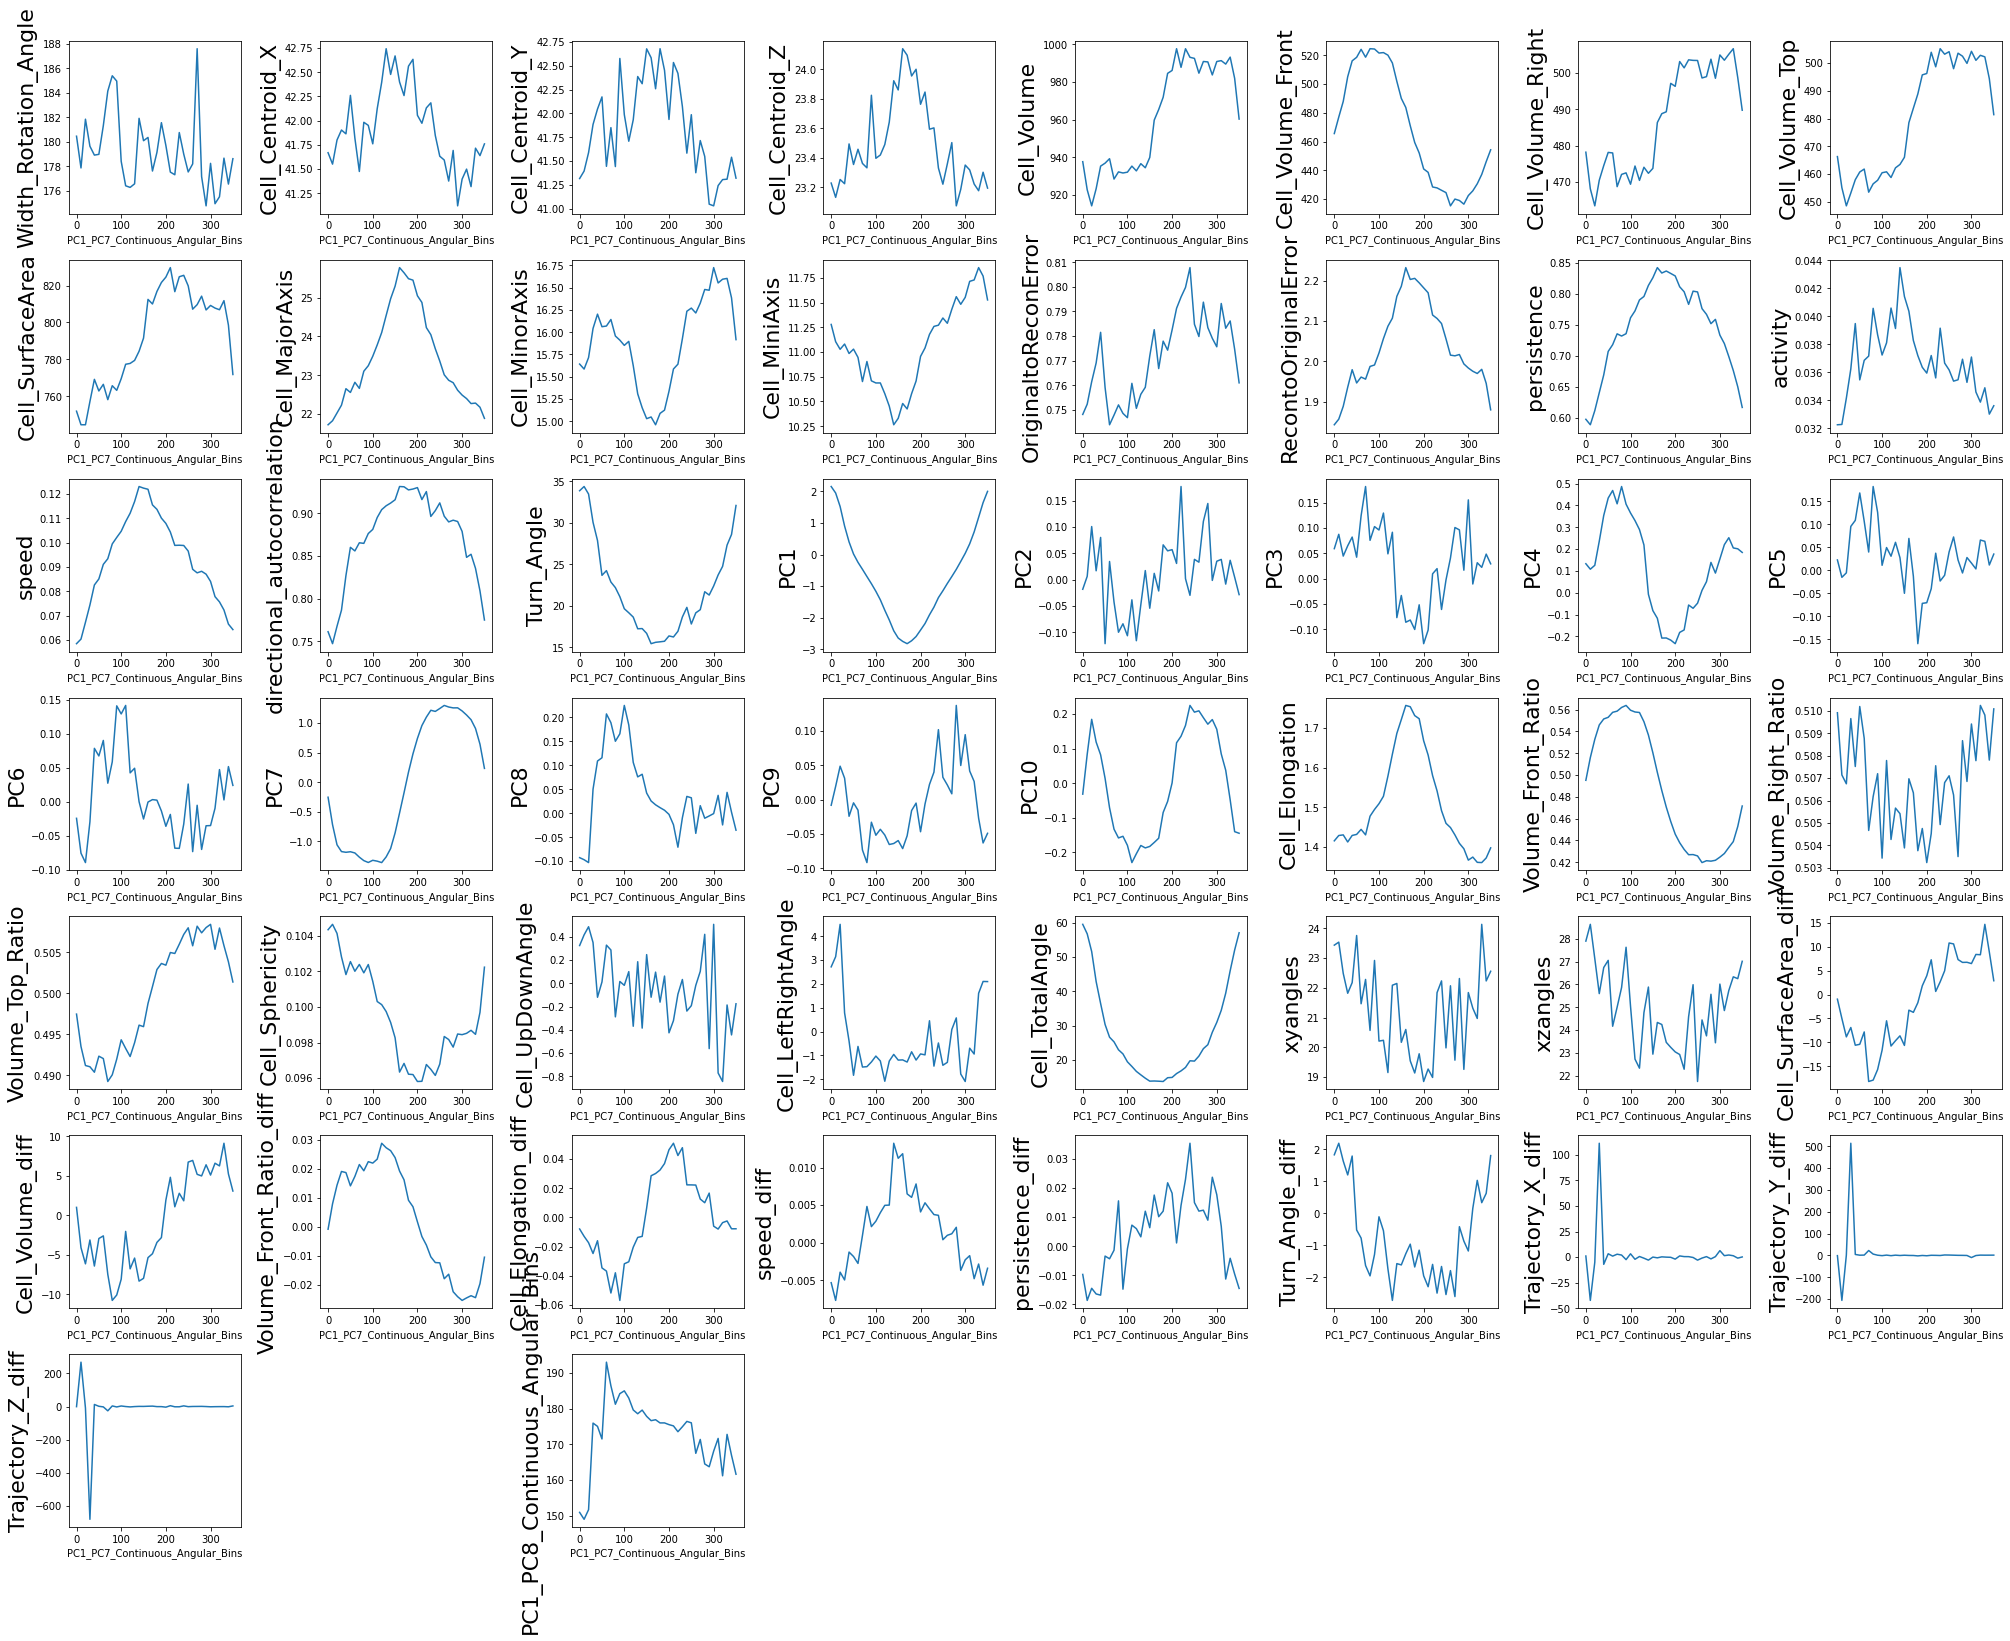

In [94]:
################# LOOK STATS AROUND 1D CYCLE ######################

newframe = TotalFrame.drop(columns =to_remove)
removeex = []
removeex.extend([x for x in newframe.columns if 'Euler' in x])
removeex.extend([x for x in newframe.columns if 'avg' in x])
removeex.extend([x for x in newframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in newframe.columns if 'intensity' in x])
removeex.extend([x for x in newframe.columns if 'Velocity' in x])
removeex.extend([x for x in newframe.columns if 'Coord' in x])
removeex.extend([x for x in newframe.columns if 'Vec' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date'])
newframe = newframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', y = newframe.iloc[:,i].name, 
                     ci = None, ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs.png', bbox_inches='tight')

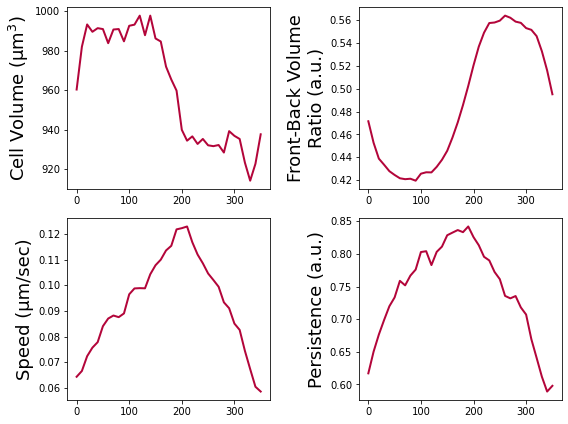

In [23]:
metlist = ['Cell_Volume', 'Volume_Front_Ratio', 'speed', 'persistence']

labelz = ['Cell Volume (µm$^3$)','Front-Back Volume\nRatio (a.u.)','Speed (µm/sec)','Persistence (a.u.)']

CoRo = math.ceil(math.sqrt(len(metlist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(4*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(metlist):
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', y = metlist[i],
                     lw = 2, color = '#b3053a', ci = None, ax = ax)
        ax.set_ylabel(metlist[i])#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(labelz[i], fontsize = 18)
        ax.set_xlabel('')
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs polished.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

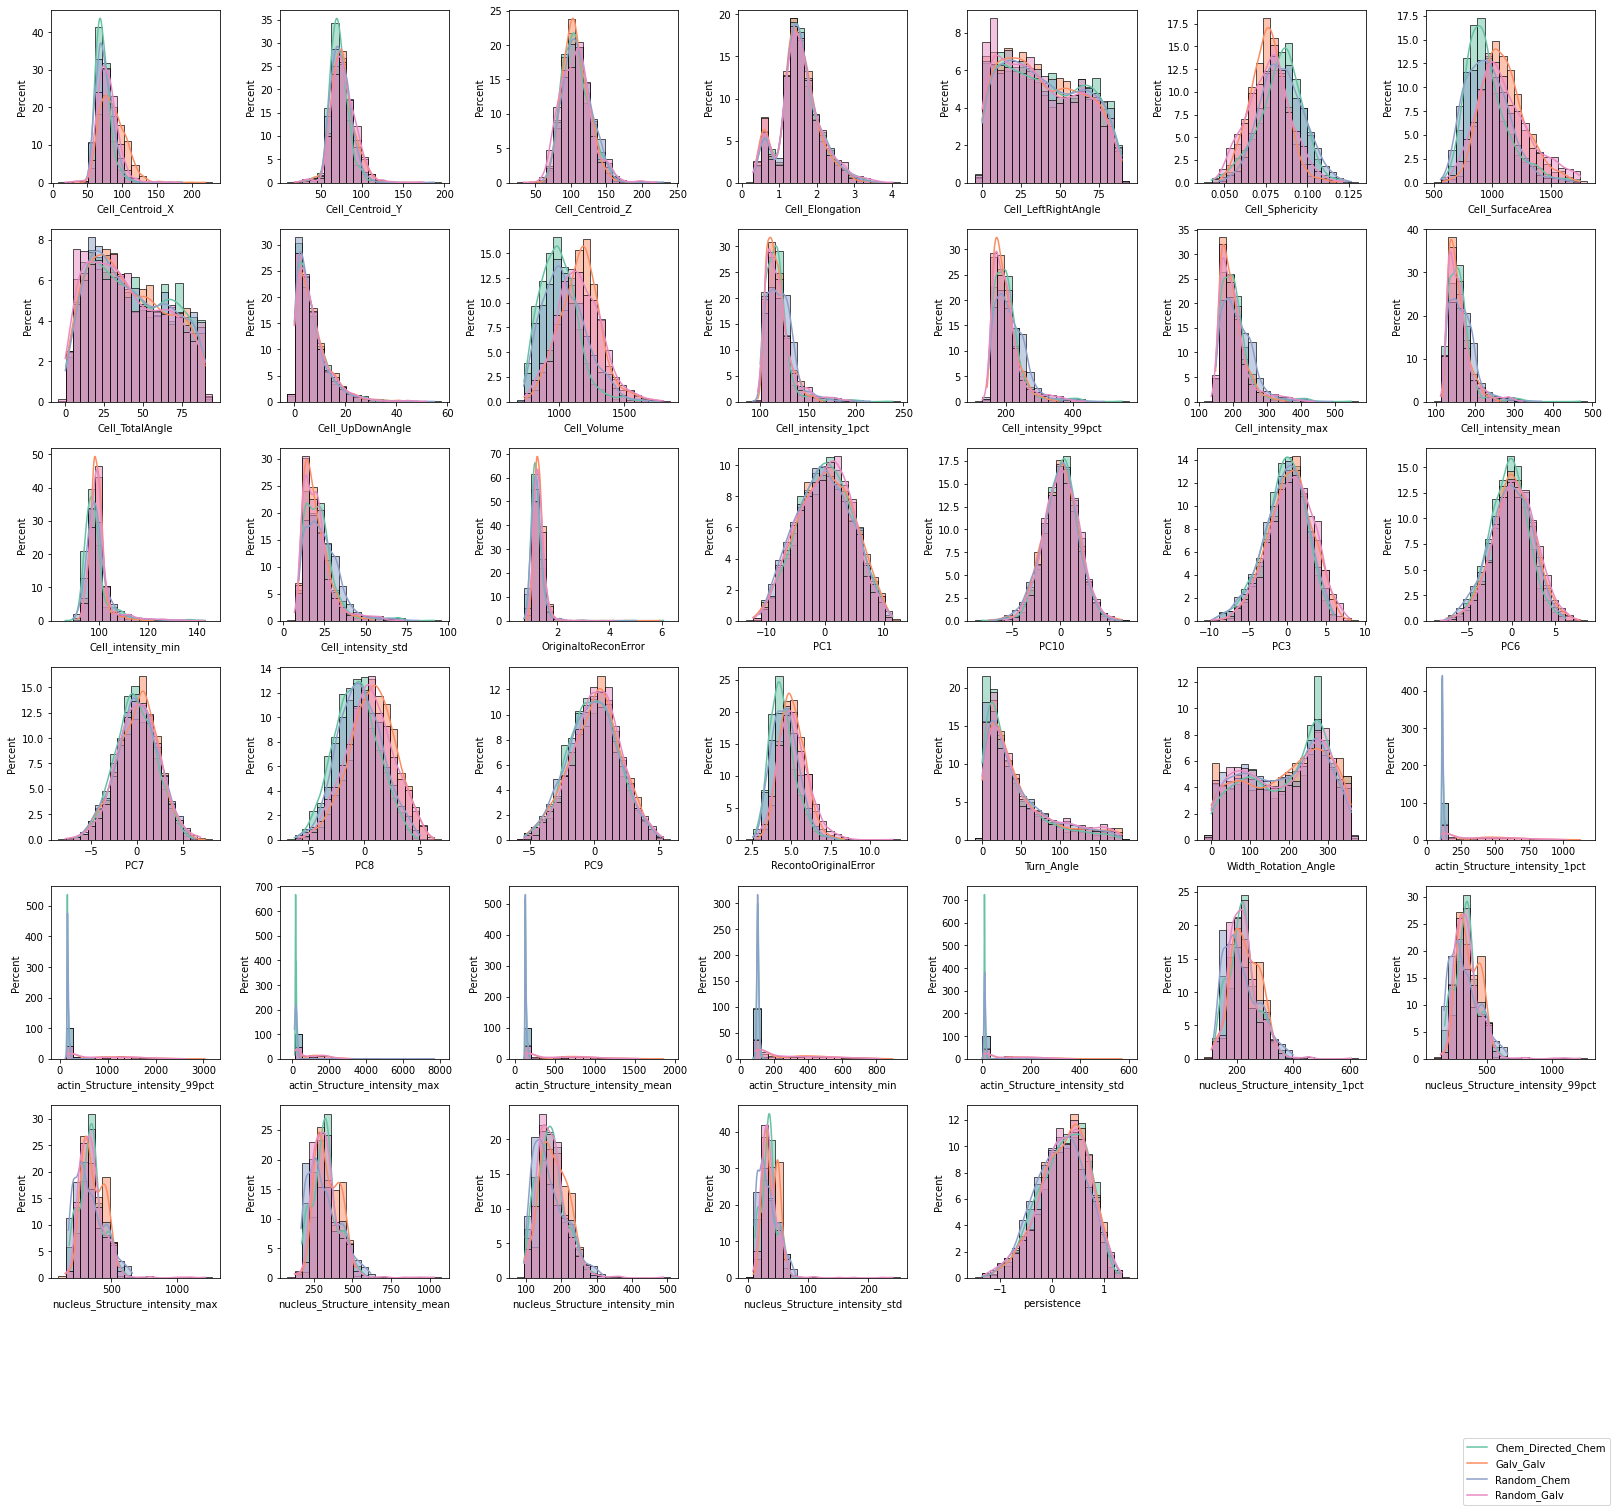

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Migration_Mode'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Migration_Mode','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


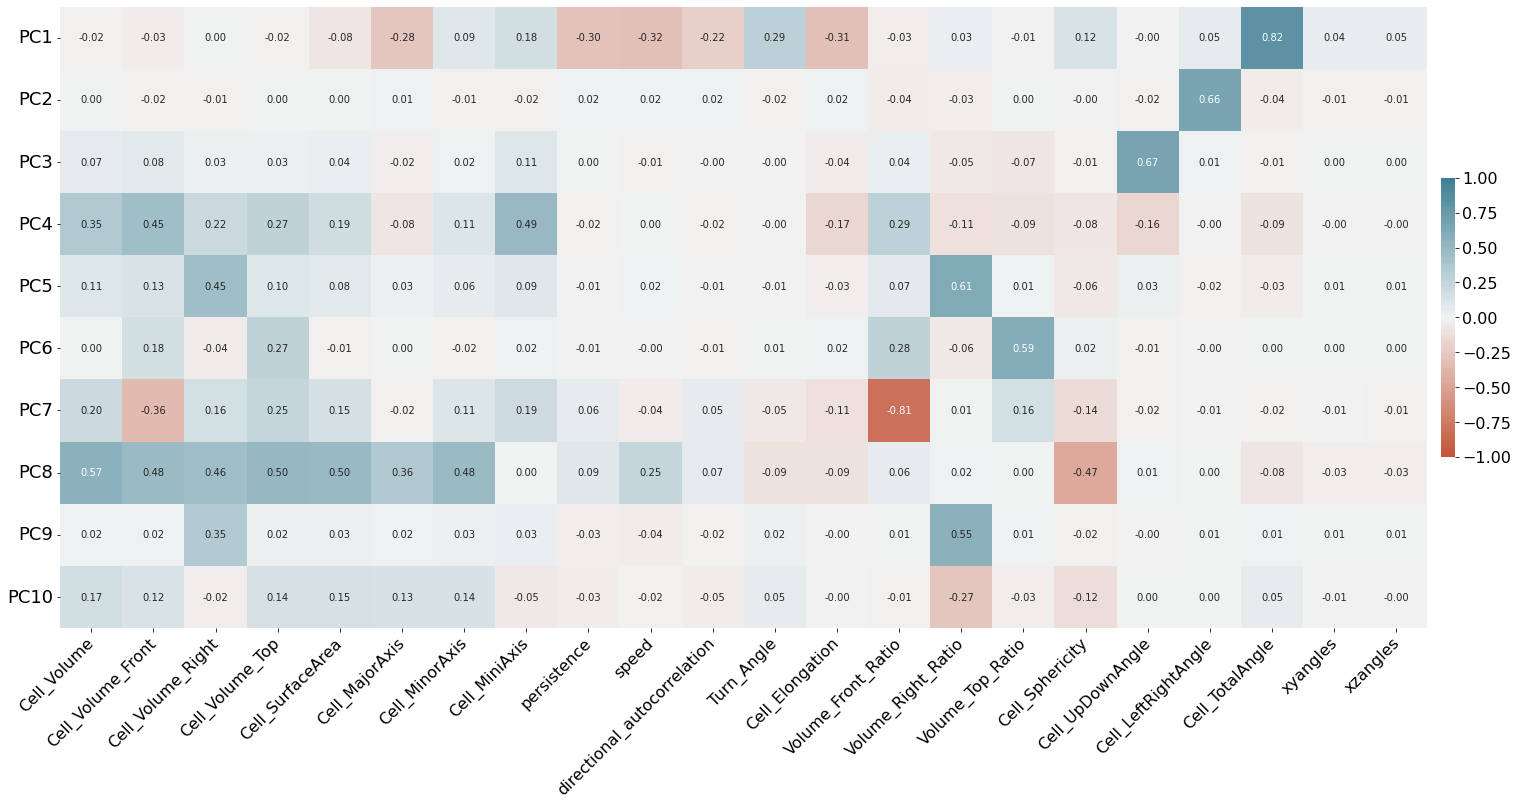

In [23]:
#correlations of shapes with PCs (PCs as rows)

#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in totalcorr.columns.to_list() if 'Migration' in i]
coldrop.extend([i for i in totalcorr.columns.to_list() if 'Vec' in i])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'Centroid' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'Cell_int' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'actin' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'nucleus' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'myosin' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'Error' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'avg' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'PC' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'diff' in x])
coldrop.extend(['frame','Width_Rotation_Angle','x','y','z','activity',
                'Date','Experiment_Number'])


PCsAndMetrics = totalcorr.loc[[x for x in totalcorr.index if 'PC' in x and 'bin' not in x and '_' not in x]]
PCsAndMetrics = PCsAndMetrics.drop(columns = coldrop)
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(
    PCsAndMetrics, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.2f',
    cbar_kws={'fraction':0.01, 'pad':0.01}#, 'shrink': 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    va = 'center',
    fontsize = 18
)
#scooch the x axis labels by a certain amount
dx = 6/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

plt.savefig(savedir + 'PC correlation with shape metrics heatmap.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


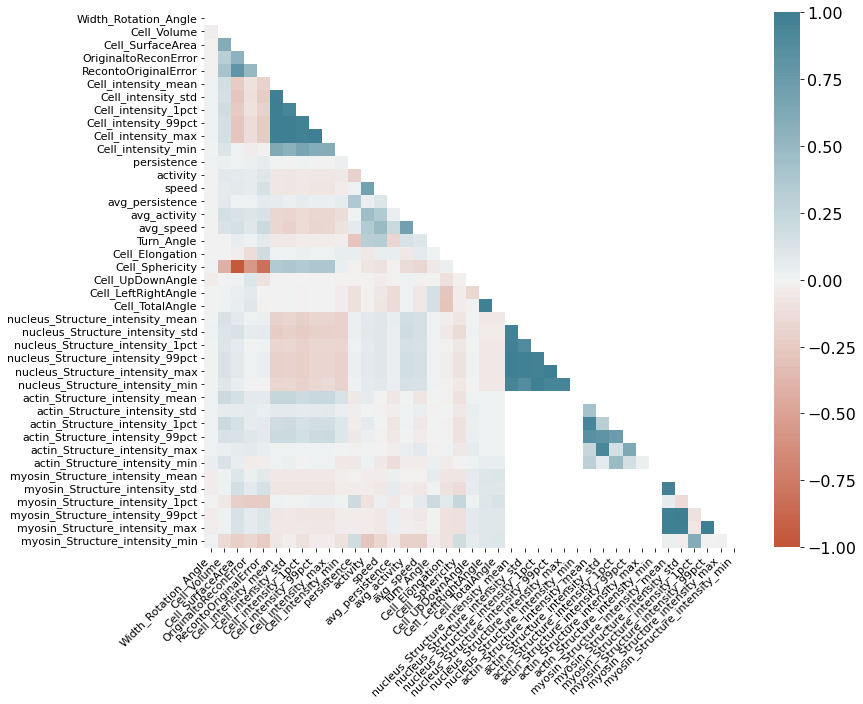

In [28]:
#get columns with nucleus and rows with cells from correlation matrix
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


NameError: name 'folder_fl' is not defined

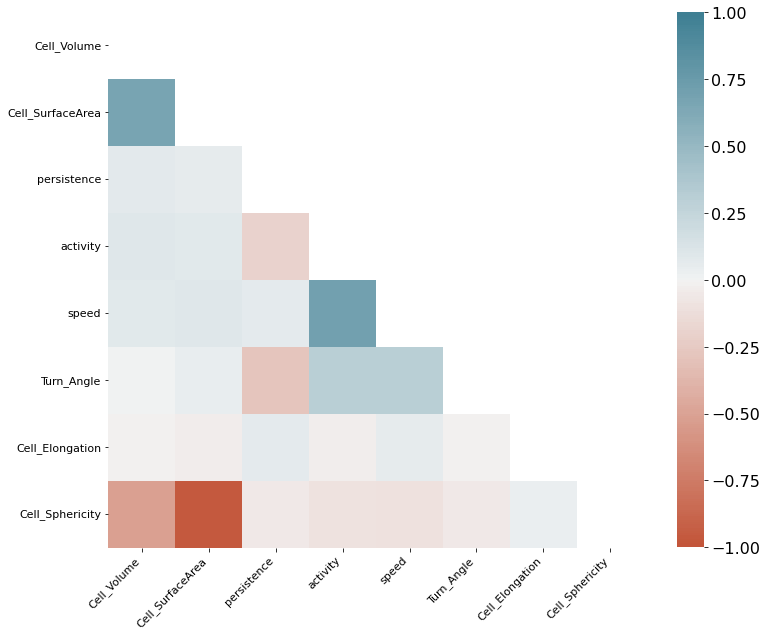

In [6]:
#get columns with nucleus and rows with cells from correlation matrix SMALLER
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_int' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'actin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'nucleus' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'myosin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Error' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
coldrop.extend(['frame','dist','Cell_UpDownAngle',
                'Cell_LeftRightAngle','Cell_TotalAngle', 'Width_Rotation_Angle',
               'x','y','z'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

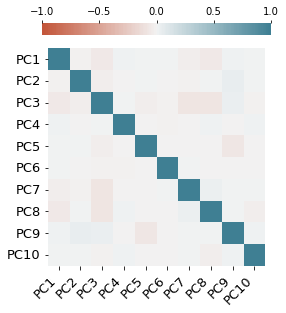

In [5]:
########################## PC Correlations #################

PCcorr = totalcorr.loc[[x for x in list(totalcorr.columns) if 'PC' in x and 'dist' not in x]].loc[:,[x for x in list(totalcorr.columns) if 'PC' in x and 'dist' not in x]]



#comparison of CELL features
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(
    PCcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82,
             'orientation':'horizontal',
             'location':'top'}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 13
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 13
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=50)

plt.savefig(savedir + 'random graph for horizontal colorbar.png', bbox_inches='tight', dpi = 500)

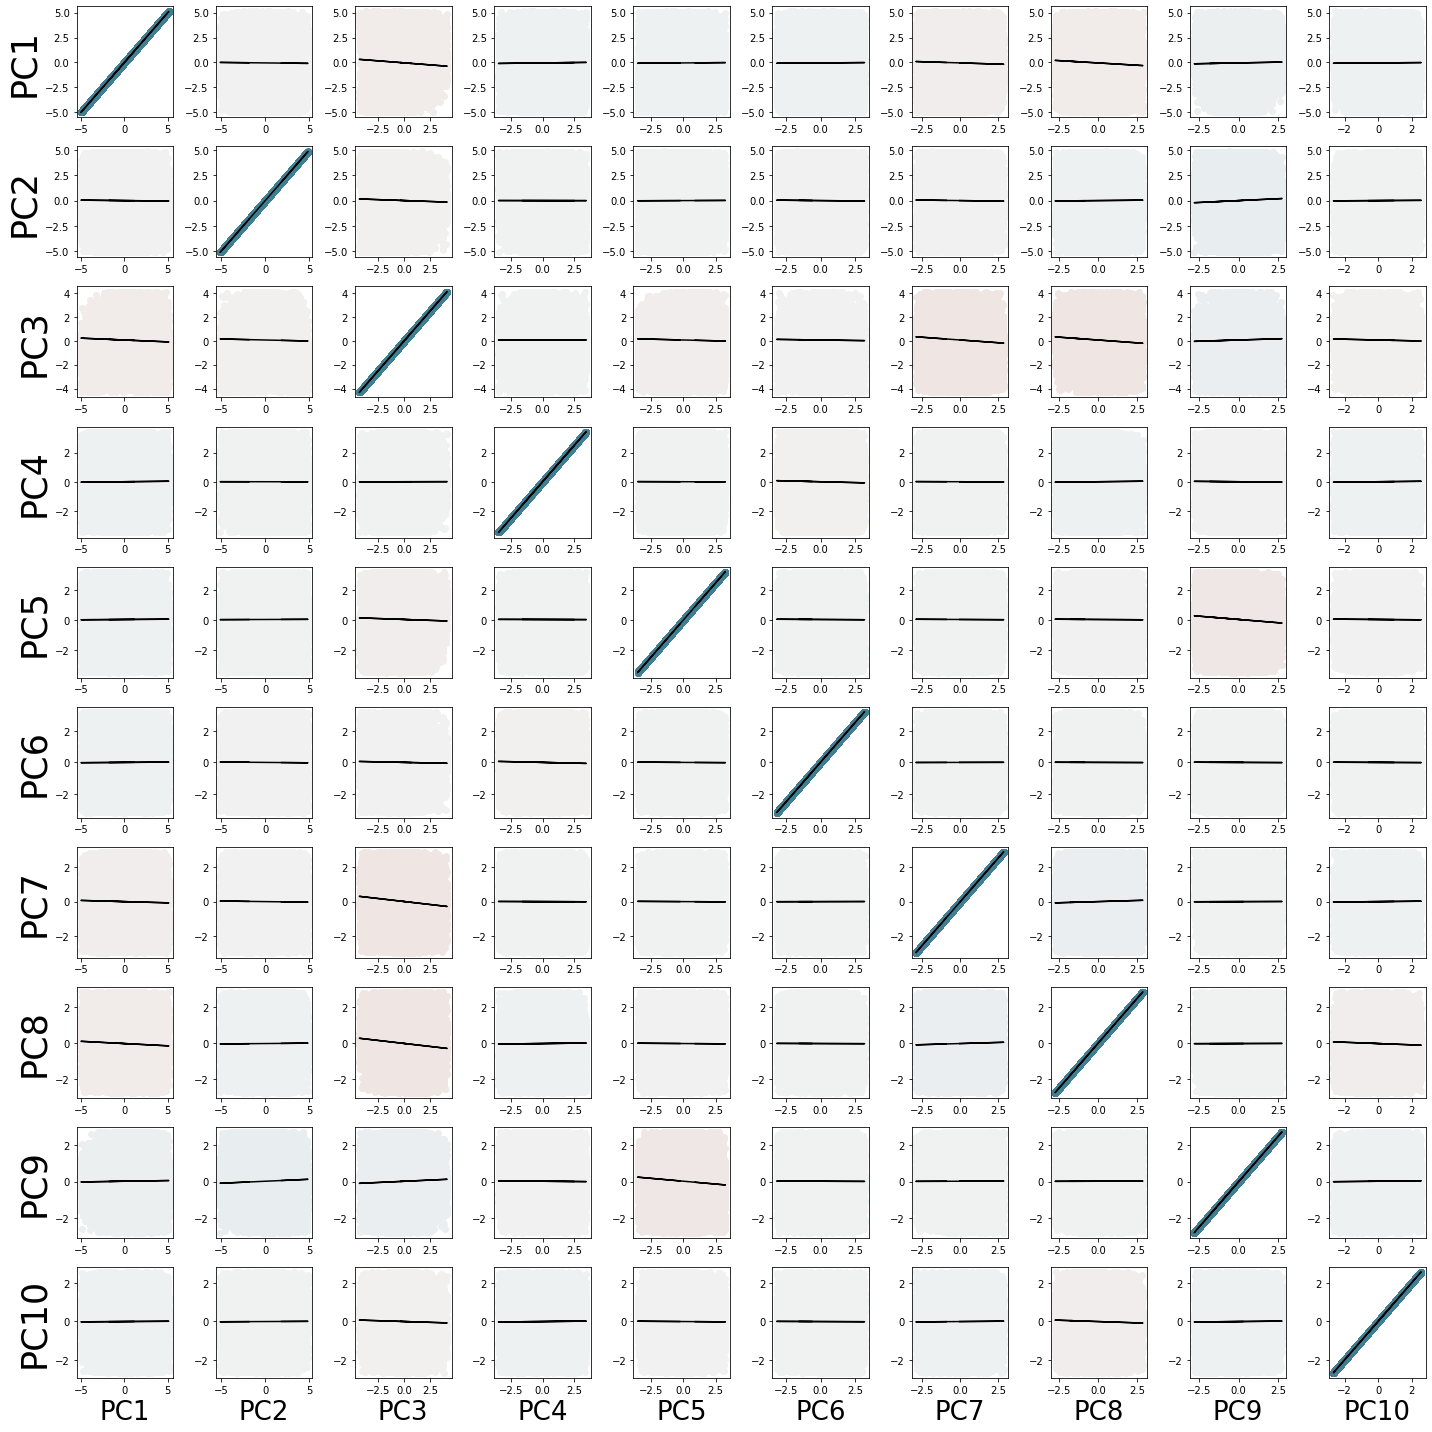

In [6]:
##################### look at scatter correlations between all PCs ###################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(PC_frame.columns), figsize=(20,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = PC_frame[f'PC{i+1}']
        y = PC_frame[f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', f'PC{i+1}']
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = PC_frame.columns
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 26) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

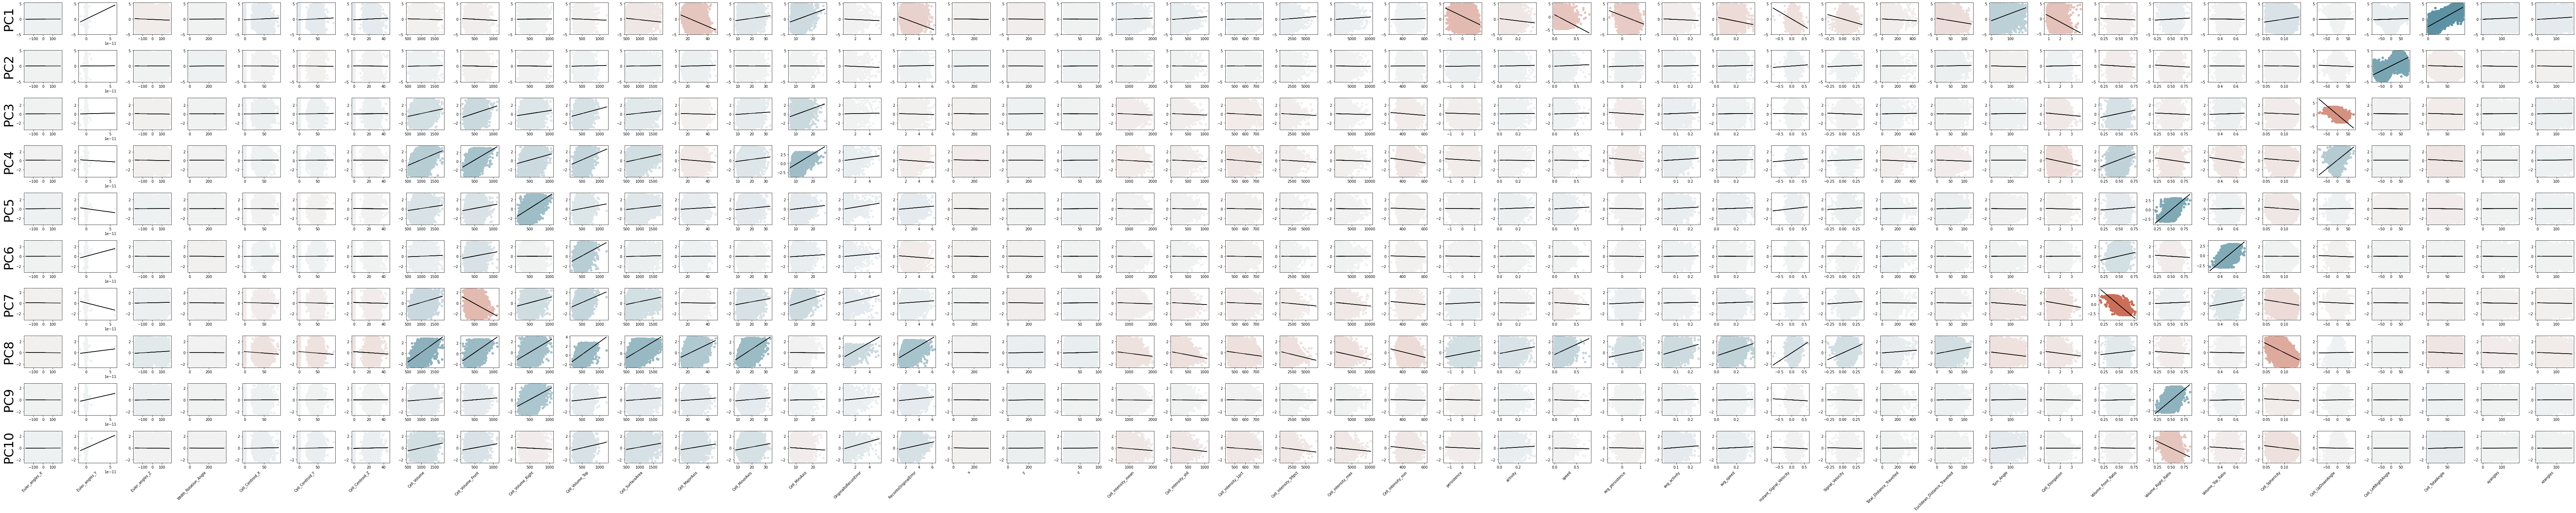

In [13]:
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'diff' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Vec' in i])
coldrop.extend(['frame','dist','Date','Experiment_Number','Treatment','Experiment'])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)

PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if '_' not in x]]



cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(100,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(metric_frame.columns[i], rotation=45, horizontalalignment='right', fontsize = 10) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(savedir+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

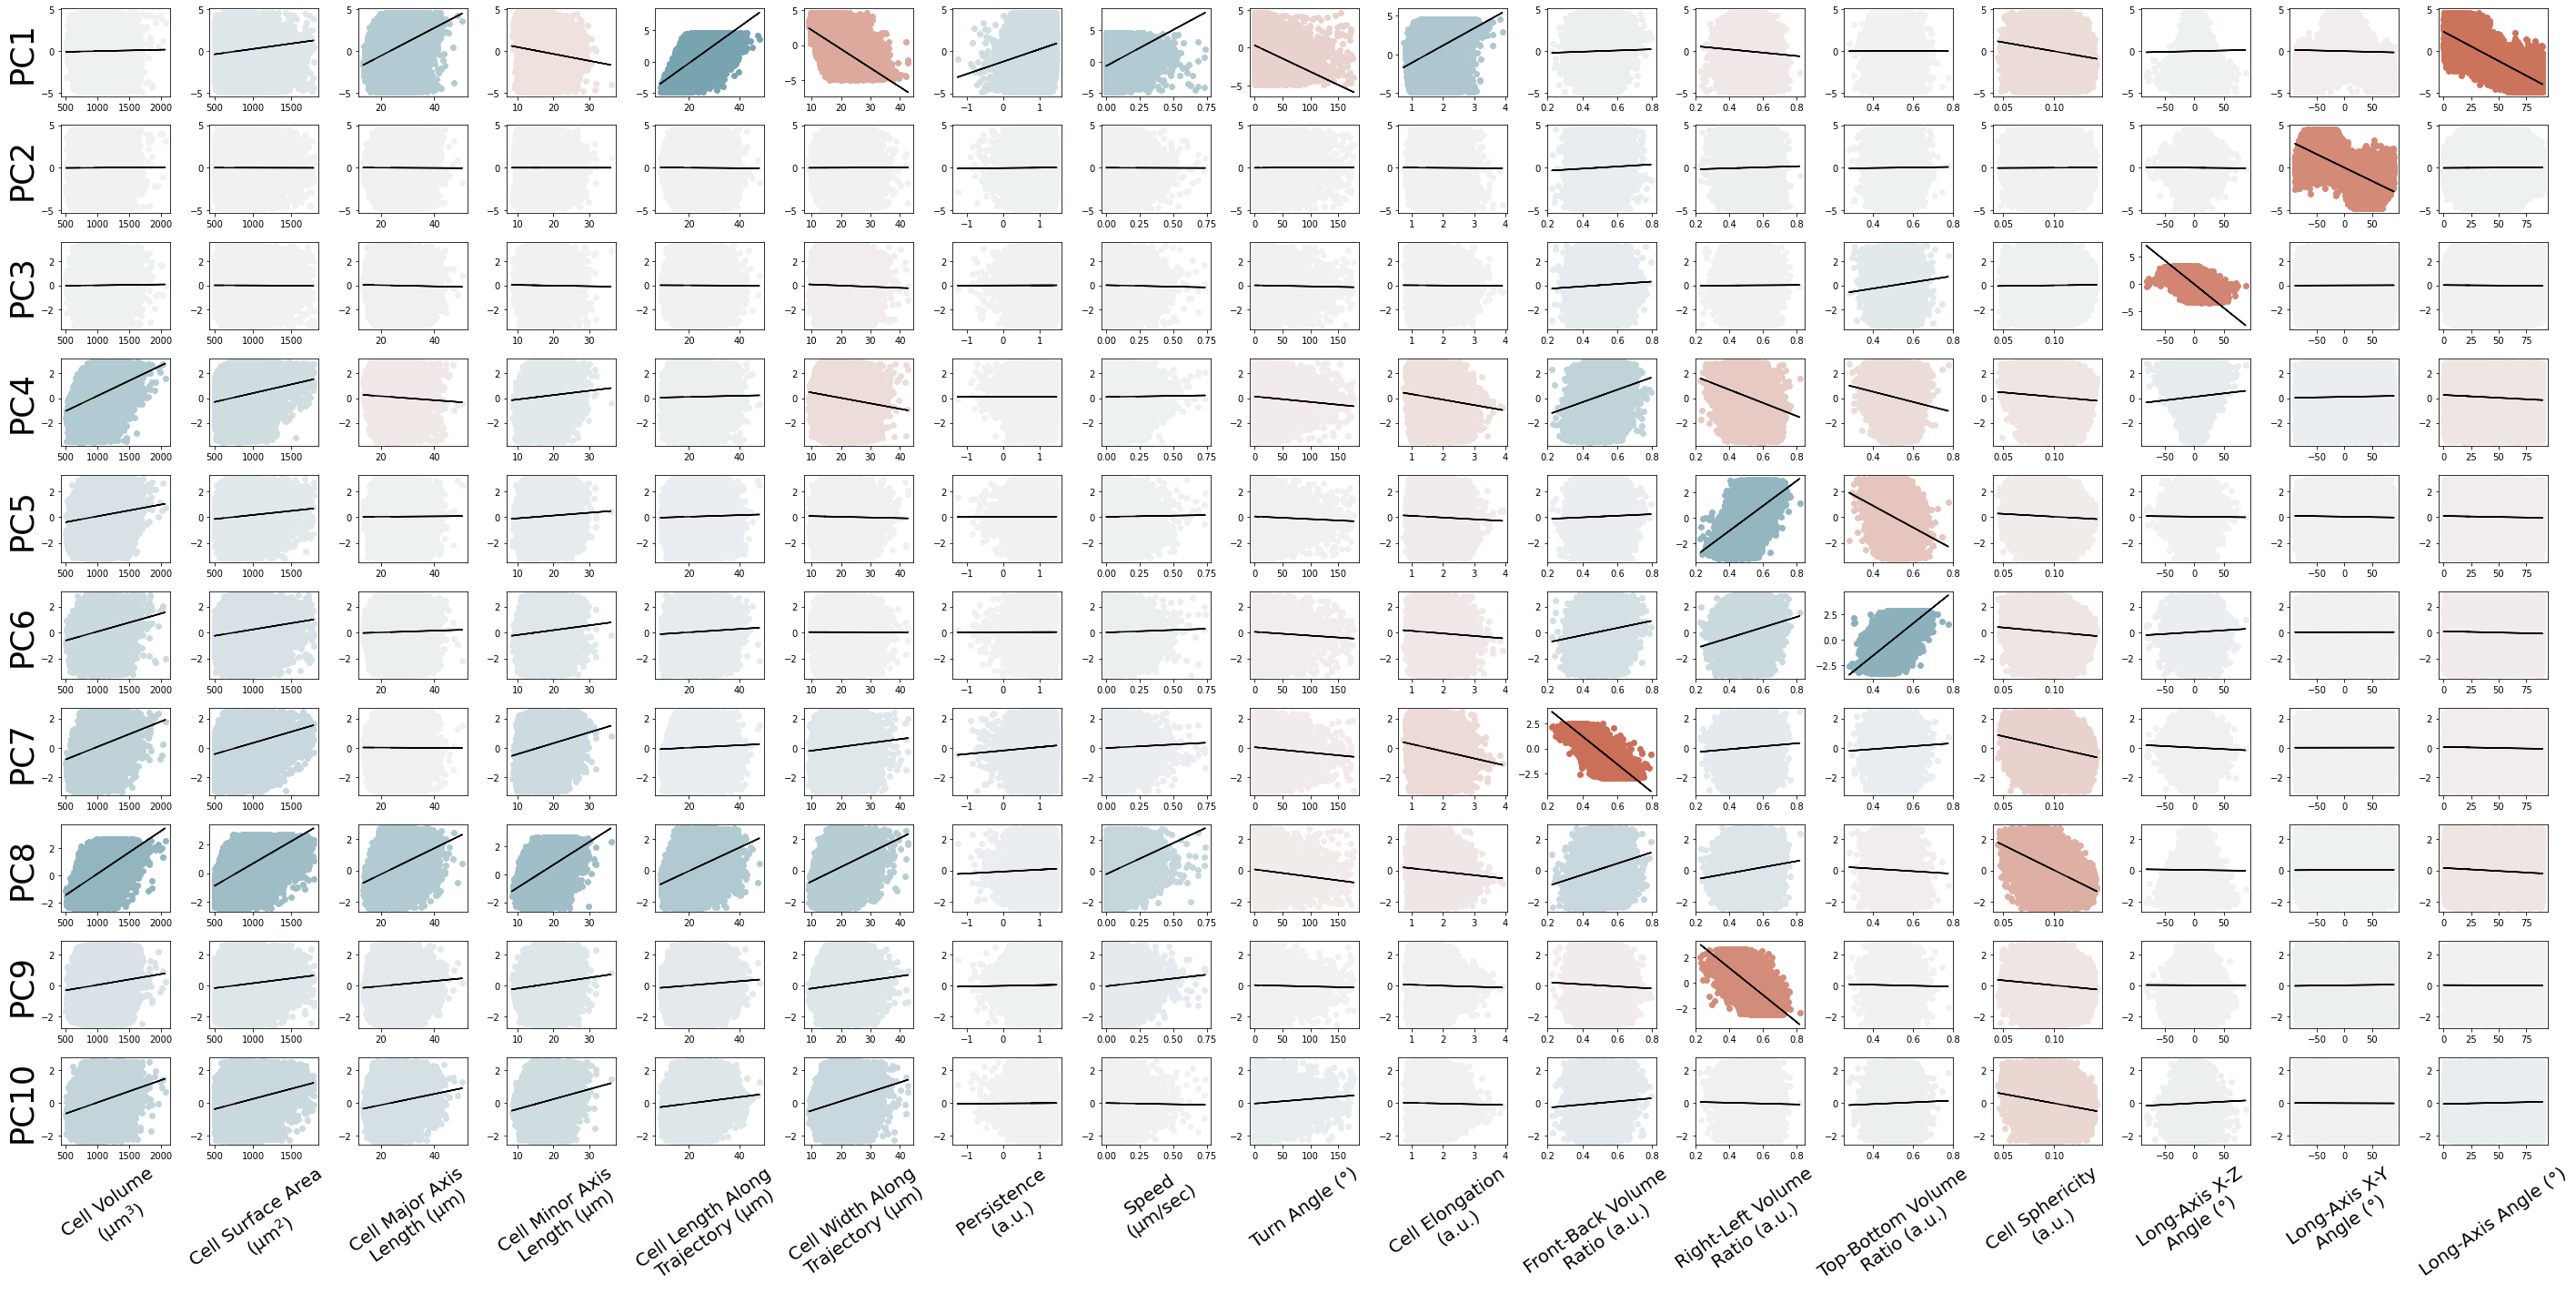

In [7]:
################ smaller PC vs metric plots for CICON ################
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Vec' in i])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_int' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'actin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'nucleus' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'myosin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Error' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'diff' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_Volume_' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if '_raw' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Travel' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Velocity' in x])
coldrop.extend(['frame','Width_Rotation_Angle','x','y','z','directional_autocorrelation','activity','structure','CellID',
                'Cell_MiniAxis','Date','Experiment_Number','Treatment','Experiment'])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)



PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'dist' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if '_' not in x]]



cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), 
                         figsize=(2.3*len(metric_frame.columns),2*len(PC_frame.columns)))#, sharex=True)
# #one colorbar for full axis
# cbar_ax = fig.add_axes([1, .2, .02, .7])
# palette = sns.diverging_palette(20, 220, n=200)
# # Convert seaborn palette to a LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list("my_cmap", palette)
# # Create a ScalarMappable object using the colormap
# sm = ScalarMappable(cmap=cmap)
# # adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=22)
# fig.colorbar(sm, cbar_ax)


for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
labelz = ['Cell Volume\n(µm$^3$)','Cell Surface Area\n(µm$^2$)','Cell Major Axis\nLength (µm)','Cell Minor Axis\nLength (µm)',
          'Cell Length Along\nTrajectory (µm)','Cell Width Along\nTrajectory (µm)','Persistence\n(a.u.)','Speed\n(µm/sec)','Turn Angle (°)',
          'Cell Elongation\n(a.u.)','Front-Back Volume\nRatio (a.u.)','Right-Left Volume\nRatio (a.u.)','Top-Bottom Volume\nRatio (a.u.)',
          'Cell Sphericity\n(a.u.)','Long-Axis X-Z\nAngle (°)','Long-Axis X-Y\nAngle (°)','Long-Axis Angle (°)']
[ax.set_xlabel(labelz[i], rotation=35, horizontalalignment='center', fontsize = 20) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(savedir+ 'PC vs. Metric scatter matrix with good labels.png', bbox_inches='tight', dpi=500)